In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

from exotic_ld import StellarLimbDarkening

import pandas as pd
import pickle

import celerite2
from celerite2 import terms


In [2]:
np.random.seed(100)

In [3]:
def set_params(params, yerrs):
    _sigma, _rho = params
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=0.0,)
    gp.compute(t, yerr=yerrs, quiet=True)

    return gp

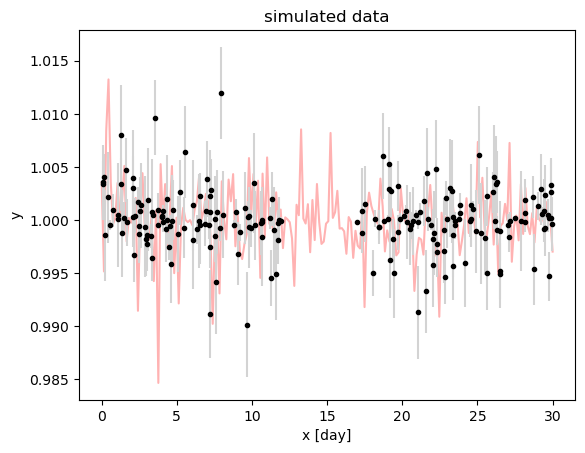

In [4]:
#2 minute cadence = 720 samples in 1 day 

t = np.sort(np.append(
        np.random.uniform(0, 12, 100), 
        np.random.uniform(17, 30, 100),
    ))  # The input coordinates must be sorted
yerr = np.random.uniform(0.0001, 0.005, len(t))
y = (1 + 0.00001*np.sin(t + 6) + yerr * np.random.randn(len(t)))

true_t = np.linspace(0, 30, len(t))
true_y = (1 + 0.0000001*np.sin(true_t + 6) + yerr * np.random.randn(len(true_t)))

plt.plot(true_t, true_y, lw=1.5, alpha=0.3, color="r", zorder=0)
plt.errorbar(t, y, yerr=yerr, fmt=".", color="black", ecolor="LightGrey", capsize=0, zorder=100)
plt.xlabel("x [day]")
plt.ylabel("y")
_ = plt.title("simulated data")


In [5]:
#Mean = y

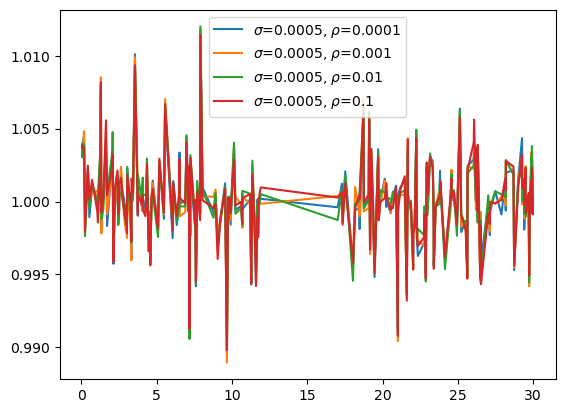

In [6]:
sig_rho_list = [[0.0005, 0.0001], [0.0005, 0.001], [0.0005, 0.01], [0.0005, 0.1]]
#Sigma - Amplitude, 
#Rho - length scale

for _sigma, _rho in sig_rho_list:
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=y)
    gp.compute(t)
    gp_sample = gp.sample()

    _label = "$\\sigma$=%s, $\\rho$=%s" % (_sigma, _rho)
    plt.plot(t, gp_sample, label = _label)


plt.legend()
plt.show()

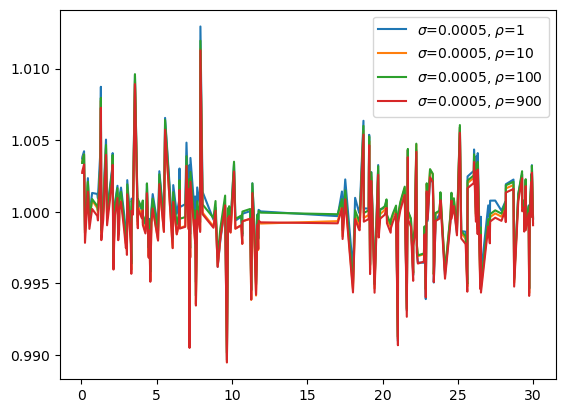

In [7]:
sig_rho_list = [[0.0005, 1], [0.0005, 10], [0.0005, 100], [0.0005, 900]]

for _sigma, _rho in sig_rho_list:
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=y)
    gp.compute(t)
    gp_sample = gp.sample()

    _label = "$\\sigma$=%s, $\\rho$=%s" % (_sigma, _rho)
    plt.plot(t, gp_sample, label = _label)


plt.legend()
plt.show()

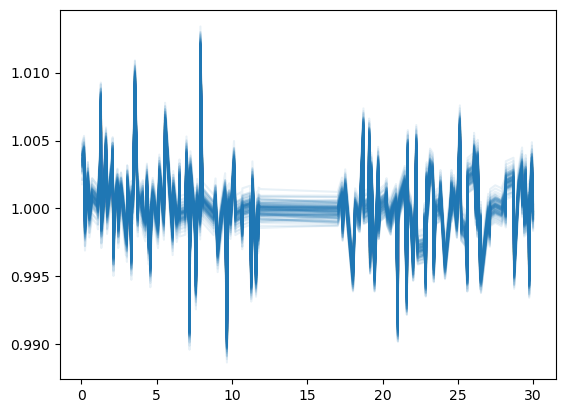

In [8]:
rho_list = np.random.uniform(0.001, 100, 100)

_sigma = 0.0005

for _rho in rho_list:
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=y)
    gp.compute(t)
    gp_sample = gp.sample()

    _label = "$\\sigma$=%s, $\\rho$=%s" % (_sigma, _rho)
    plt.plot(t, gp_sample, label = _label, color="C0", alpha=0.1)

# plt.legend()
plt.show()

In [9]:
#Mean = 1.0

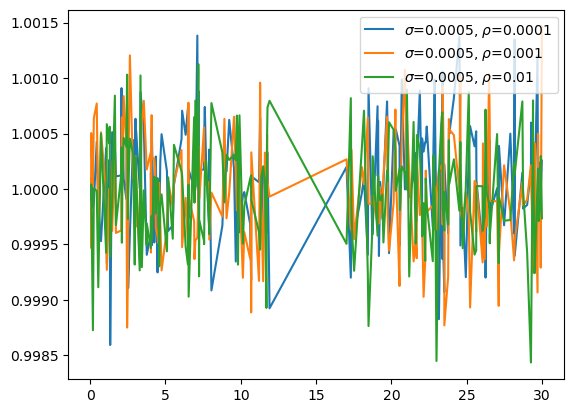

In [10]:
sig_rho_list = [[0.0005, 0.0001], [0.0005, 0.001], [0.0005, 0.01]]
#Sigma - Amplitude, 
#Rho - length scale

for _sigma, _rho in sig_rho_list:
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=1.0)
    gp.compute(t)
    gp_sample = gp.sample()

    _label = "$\\sigma$=%s, $\\rho$=%s" % (_sigma, _rho)
    plt.plot(t, gp_sample, label = _label)


plt.legend(loc='upper right')
plt.show()

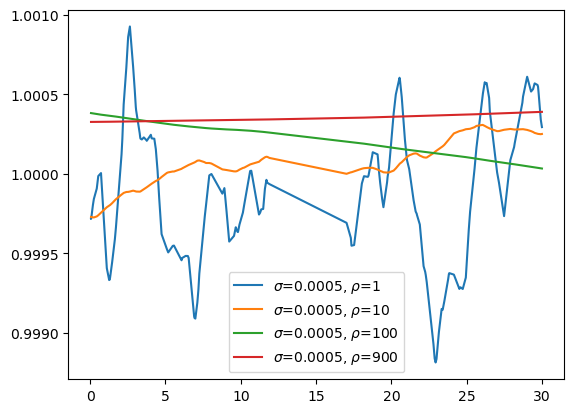

In [11]:
sig_rho_list = [[0.0005, 1], [0.0005, 10], [0.0005, 100], [0.0005, 900]]

for _sigma, _rho in sig_rho_list:
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=1.0)
    gp.compute(t)
    gp_sample = gp.sample()

    _label = "$\\sigma$=%s, $\\rho$=%s" % (_sigma, _rho)
    plt.plot(t, gp_sample, label = _label)


plt.legend()
plt.show()

In [12]:
t = np.arange(0, 30, 0.01)

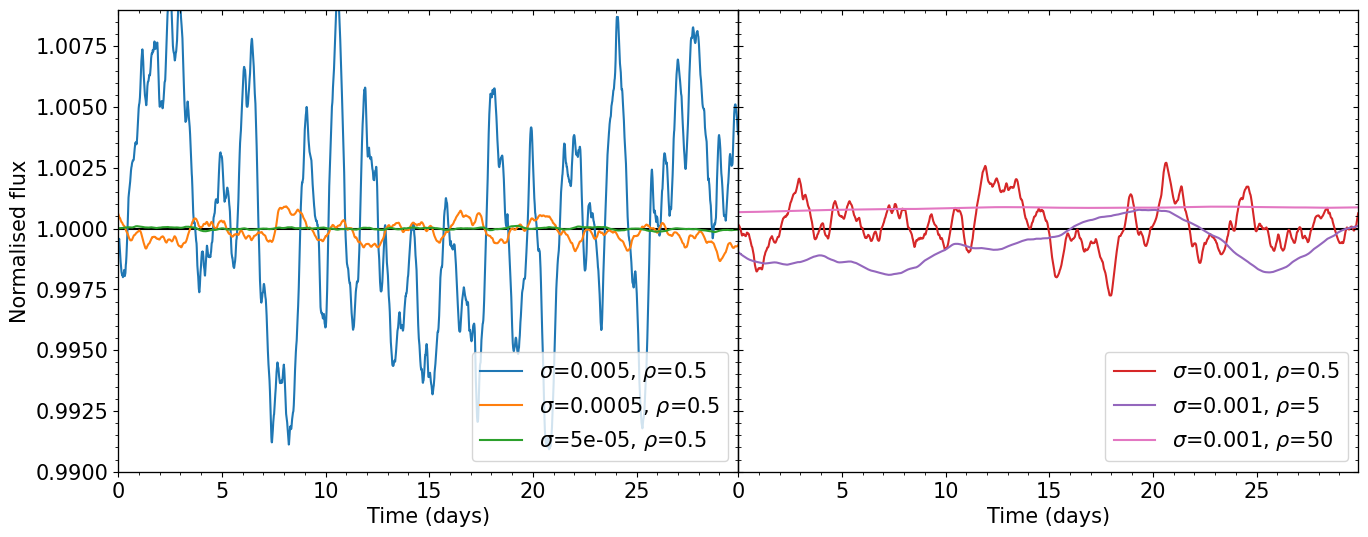

In [13]:
fontsize = 15
colour_list1 = ['#1f77b4', '#ff7f0e', '#2ca02c']
colour_list2 = ['#d62728', '#9467bd', '#e377c2']

# [u'', u'', u'', u'', u'', u'', u'', u'#7f7f7f', u'#bcbd22', u'#17becf']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

"""
Varying amplitude

"""

sig_rho_list = [[0.005, 0.5], [0.0005, 0.5], [0.00005, 0.5]]


for [_sigma, _rho], colour in zip(sig_rho_list, colour_list1):
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=1.0)
    gp.compute(t)
    gp_sample = gp.sample()

    _label = "$\\sigma$=%s, $\\rho$=%s" % (_sigma, _rho)
    ax1.plot(t, gp_sample, label = _label, color=colour)

ax1.axhline(1, color="Black", zorder=0)
ax1.set_xlabel("Time (days)", size=fontsize)
ax1.set_ylabel("Normalised flux", size=fontsize)
ax1.set_xlim(0, 29.9)
ax1.set_ylim(0.99, 1.009)


ax1.xaxis.set_tick_params(labelsize=fontsize)
ax1.yaxis.set_tick_params(labelsize=fontsize)

# Mirror y
ax1y = ax1.twinx()
ax1y.set_ylim(ax1.get_ylim())
ax1y.get_yaxis().set_ticklabels([])
ax1y.tick_params(which="both", direction="in")

# Mirror x
ax1x = ax1.twiny()
ax1x.set_xlim(ax1.get_xlim())
ax1x.get_xaxis().set_ticklabels([])
ax1x.tick_params(which="both", direction="in")

ax1x.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1y.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

"""
Varying timescale
"""

sig_rho_list = [[0.001, 0.5], [0.001, 5], [0.001, 50]]

for [_sigma, _rho], colour in zip(sig_rho_list, colour_list2):
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=1.0)
    gp.compute(t)
    gp_sample = gp.sample()

    _label = "$\\sigma$=%s, $\\rho$=%s" % (_sigma, _rho)
    ax2.plot(t, gp_sample, label = _label, color=colour)

ax2.axhline(1, color="Black", zorder=0)
ax2.set_xlabel("Time (days)", size=fontsize)
ax2.set_xlim(0, 29.9)
ax2.set_ylim(ax1.get_ylim())
ax2.get_yaxis().set_ticklabels([])
ax2.tick_params(axis="y", which="both", direction="in")

ax2.xaxis.set_tick_params(labelsize=fontsize)
ax2.yaxis.set_tick_params(labelsize=fontsize)

# Mirror y
ax2y = ax2.twinx()
ax2y.set_ylim(ax2.get_ylim())
ax2y.get_yaxis().set_ticklabels([])
ax2y.tick_params(which="both", direction="in")

# Mirror x
ax2x = ax2.twiny()
ax2x.set_xlim(ax2.get_xlim())
ax2x.get_xaxis().set_ticklabels([])
ax2x.tick_params(which="both", direction="in")

ax2x.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2y.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())


ax1.legend(loc='lower right', prop={'size': fontsize})
ax2.legend(loc='lower right', prop={'size': fontsize})

plt.subplots_adjust(wspace=0)
plt.show()

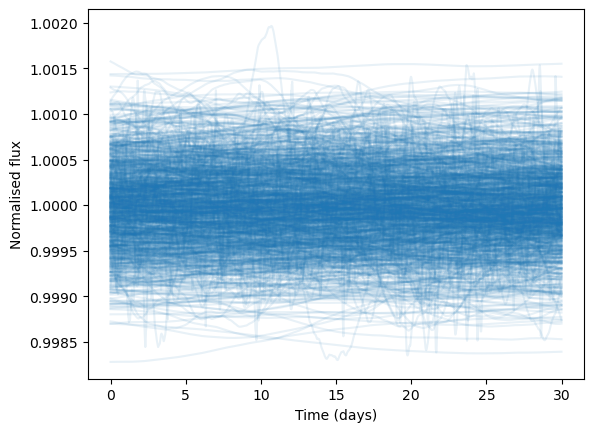

In [14]:
rho_list = np.random.uniform(0.001, 100, 1000)

_sigma = 0.0005

for _rho in rho_list:
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=1.0)
    gp.compute(t)
    gp_sample = gp.sample()

    _label = "$\\sigma$=%s, $\\rho$=%s" % (_sigma, _rho)
    plt.plot(t, gp_sample, label = _label, color="C0", alpha=0.1)

plt.xlabel("Time (days)")
plt.ylabel("Normalised flux")
# plt.legend()
plt.show()